In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, Column, Integer, String, Float, Date
from sqlalchemy.orm import declarative_base, sessionmaker
from dotenv import load_dotenv
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
load_dotenv()

USER = os.getenv("DB_USER")
PASSWORD = os.getenv("DB_PASSWORD")
HOST = os.getenv("DB_HOST")
DATABASE_RAW = os.getenv("DB_RAW")
DB_CLEAN = os.getenv("DB_CLEAN")

engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}/{DATABASE_RAW}")

query = "SELECT * FROM accidents"
df = pd.read_sql(query, engine)

df.head(10)

,id,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,1,2023-07-29 13:00:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,...,NO INDICATION OF INJURY,0,0,0,0,0,3,13,7,7
1,2,2023-08-13 00:11:00,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO INDICATION OF INJURY,0,0,0,0,0,2,0,1,8
2,3,2021-12-09 10:30:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO INDICATION OF INJURY,0,0,0,0,0,3,10,5,12
3,4,2023-08-09 19:55:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NONINCAPACITATING INJURY,5,0,0,5,0,0,19,4,8
4,5,2023-08-19 14:55:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,...,NO INDICATION OF INJURY,0,0,0,0,0,3,14,7,8
5,6,2023-09-06 00:59:00,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,WET,UNKNOWN,...,NONINCAPACITATING INJURY,2,0,0,2,0,0,0,4,9
6,7,2022-12-20 11:45:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR TO FRONT,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO INDICATION OF INJURY,0,0,0,0,0,2,11,3,12
7,8,2023-09-20 14:38:00,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),"CURVE, LEVEL",DRY,NO DEFECTS,...,NONINCAPACITATING INJURY,1,0,0,1,0,1,14,4,9
8,9,2018-06-04 18:42:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO INDICATION OF INJURY,0,0,0,0,0,3,18,2,6
9,10,2023-09-07 17:30:00,STOP SIGN/FLASHER,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO INDICATION OF INJURY,0,0,0,0,0,4,17,5,9


In [3]:

df["crash_year"] = pd.to_datetime(df["crash_date"], format="%m/%d/%Y %I:%M:%S %p").dt.year
df["crash_day_of_month"] = pd.to_datetime(df["crash_date"], format="%m/%d/%Y %I:%M:%S %p").dt.day


In [4]:


def limpiar_damage(valor):
    if pd.isna(valor):
        return np.nan, np.nan
    valor = valor.strip().upper()
    
    if "OVER" in valor:  
        return 1500, np.nan
    elif "$" in valor and "-" in valor:  
        valores = [int(v.replace("$", "").replace(",", "")) for v in valor.split(" - ")]
        return valores[0], valores[1]
    else: 
        return np.nan, np.nan


df[["damage_min", "damage_max"]] = df["damage"].apply(lambda x: pd.Series(limpiar_damage(x)))



In [5]:
columnas_eliminar = ["crash_date", "damage"]
df = df.drop(columns=[col for col in columnas_eliminar if col in df.columns])

In [6]:
df.isnull().sum()

id                                    0
traffic_control_device                0
weather_condition                     0
lighting_condition                    0
first_crash_type                      0
trafficway_type                       0
alignment                             0
roadway_surface_cond                  0
road_defect                           0
crash_type                            0
intersection_related_i                0
prim_contributory_cause               0
num_units                             0
most_severe_injury                    0
injuries_total                        0
injuries_fatal                        0
injuries_incapacitating               0
injuries_non_incapacitating           0
injuries_reported_not_evident         0
injuries_no_indication                0
crash_hour                            0
crash_day_of_week                     0
crash_month                           0
crash_year                            0
crash_day_of_month                    0


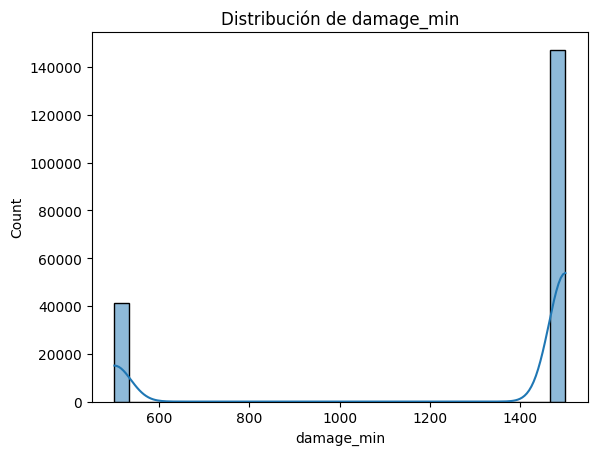

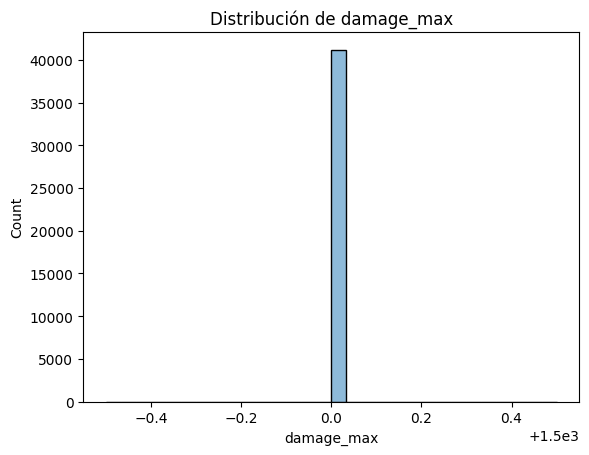

In [7]:

sns.histplot(df["damage_min"], bins=30, kde=True)
plt.title("Distribución de damage_min")
plt.show()

sns.histplot(df["damage_max"], bins=30, kde=True)
plt.title("Distribución de damage_max")
plt.show()


In [8]:

mode_damage_min = df['damage_min'].mode()[0]
df['damage_min'] = df['damage_min'].fillna(mode_damage_min)


median_damage_max = df['damage_max'].median()
df['damage_max'] = df['damage_max'].fillna(median_damage_max)


df.isnull().sum()


id                               0
traffic_control_device           0
weather_condition                0
lighting_condition               0
first_crash_type                 0
trafficway_type                  0
alignment                        0
roadway_surface_cond             0
road_defect                      0
crash_type                       0
intersection_related_i           0
prim_contributory_cause          0
num_units                        0
most_severe_injury               0
injuries_total                   0
injuries_fatal                   0
injuries_incapacitating          0
injuries_non_incapacitating      0
injuries_reported_not_evident    0
injuries_no_indication           0
crash_hour                       0
crash_day_of_week                0
crash_month                      0
crash_year                       0
crash_day_of_month               0
damage_min                       0
damage_max                       0
dtype: int64

In [9]:
load_dotenv()

engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOST}/{DB_CLEAN}")

df.to_sql("accidents_clean", con=engine, if_exists="replace", index=False)

print("Datos limpios guardados en la base de datos accidents_clean")

Datos limpios guardados en la base de datos accidents_clean
